In [1]:
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import torch

In [2]:
class CNN(Module):
    # define model elements
    def __init__(self, n_channels):
        super(CNN, self).__init__()
        # input to first hidden layer
        self.hidden1 = Conv2d(n_channels, 32, (3,3))
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # first pooling layer
        self.pool1 = MaxPool2d((2,2), stride=(2,2))
        # second hidden layer
        self.hidden2 = Conv2d(32, 32, (3,3))
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # second pooling layer
        self.pool2 = MaxPool2d((2,2), stride=(2,2))
        # fully connected layer
        self.hidden3 = Linear(5*5*32, 100)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        # output layer
        self.hidden4 = Linear(100, 10)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = Softmax(dim=1)

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.pool1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.pool2(X)
        # flatten
        X = X.view(-1, 4*4*50)
        # third hidden layer
        X = self.hidden3(X)
        X = self.act3(X)
        # output layer
        X = self.hidden4(X)
        X = self.act4(X)
        return X

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
trans = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

In [5]:
path = '~/.torch/datasets/mnist'

train = MNIST(path, train=True, download=True, transform=trans)
test = MNIST(path, train=False, download=True, transform=trans)

In [6]:
print(train.data.shape)
print(test.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [7]:
import matplotlib.pyplot as plt
def im_plot(img):
    plt.imshow(img)
    plt.show()

In [8]:
img_1 = train.data[0]

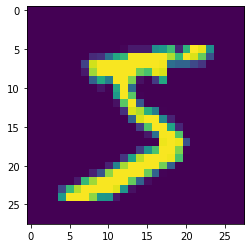

In [9]:
im_plot(img_1)

In [10]:
from torchvision.utils import save_image

In [11]:
test_img_1 = test.data[0].float()
test_img_2 = test.data[1].float()
test_img_3 = test.data[2].float()

save_image(test_img_1,'MNIST_Data/img_1.png')
save_image(test_img_2,'MNIST_Data/img_2.png')
save_image(test_img_3,'MNIST_Data/img_3.png')

In [12]:
train_dl = DataLoader(train, batch_size=64, shuffle=True)
test_dl = DataLoader(test, batch_size=1024, shuffle=False)

In [13]:
def train_model(train_dl, model):
    # define the optimization
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # enumerate epochs
    for epoch in range(20):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            inputs, targets = inputs.to(device), targets.to(device)
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

In [14]:
model = CNN(1).to(device)

In [15]:
train_model(train_dl,model)

In [16]:
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().cpu().numpy()
        actual = targets.cpu().numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

In [17]:
acc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc)

Accuracy: 0.992


In [18]:
torch.save(model.state_dict(),'MNIST_Data/model.pth')